## Imports

In [2]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet 
import statsmodels.tsa.stattools as ts
 
from helper import clean_data
from helper import vix_prime_combine
from helper import dftest
from helper import split_data

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data loading & cleaning

In [8]:
pct, vix_close , prime, weekly_vix, monthly_vix = clean_data()

In [11]:
weekly_pct = pct.resample('W').sum()

In [18]:
weekly_pct_df = pd.DataFrame(weekly_pct)

In [19]:
weekly_pct_df.shape

(1516, 1)

In [3]:
vp_df = vix_prime_combine(monthly_vix,prime) ## combines monthly vix data & monthly prime data

## Let's split data up into test and train

In [20]:
train, validation, test = split_data(weekly_pct_df,52)

Those are some bad predictions! I'm going to look at RMSE as well.

## Default Prophet

In [21]:
from helper import RMSE
from helper import optimize_ar_rmse

In [22]:
from helper import format_prophet_data

In [23]:
p_train,p_validation = format_prophet_data(train,validation)

/Users/nmp256/Code/datascience/metis/luther/helper.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  p_train['ds']= p_train.index
/Users/nmp256/Code/datascience/metis/luther/helper.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  p_validation['ds']=p_validation.index


In [24]:
m = Prophet()
m.fit(p_train)
#future = m.make_future_dataframe(periods=213)
forecast = m.predict(p_validation)
#m.plot_components(forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


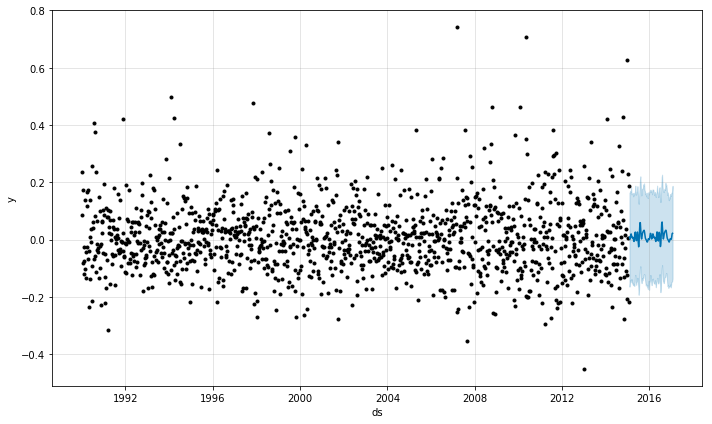

In [25]:
fig1 = m.plot(forecast)

In [26]:
join_df = forecast[['ds','yhat']]

In [27]:
join_df.set_index('ds',inplace=True)

In [28]:
p_validation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2015-02-01 to 2017-01-22
Freq: W-SUN
Data columns (total 2 columns):
y     104 non-null float64
ds    104 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [29]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2015-02-01 to 2017-01-22
Data columns (total 1 columns):
yhat    104 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB


In [30]:
p_validation['preds']=join_df['yhat']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


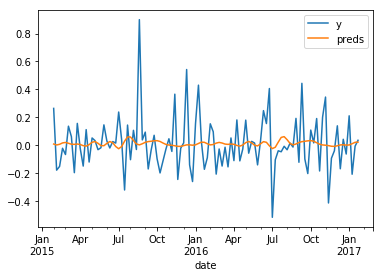

In [31]:
p_validation[['y','preds']].plot()

In [32]:
RMSE(p_validation.y.values,p_validation.preds.values)

0.19369773191044112

In [26]:
from helper import MAPE

In [25]:
#got MAPE code from here: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
def MAPE2(y_true,y_pred):
    lala
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

In [27]:
MAPE(p_validation.y.values,p_validation.preds.values)

50.51449652444866

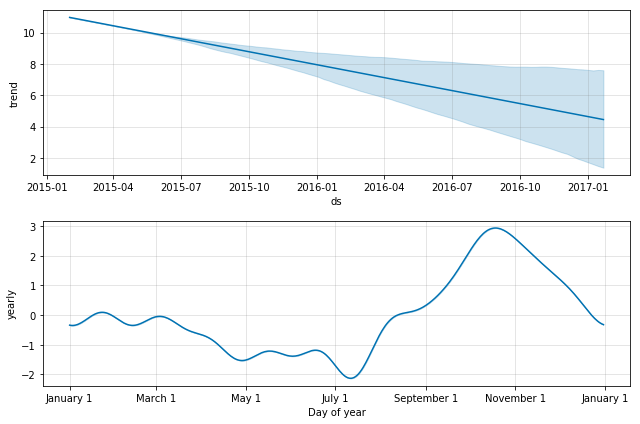

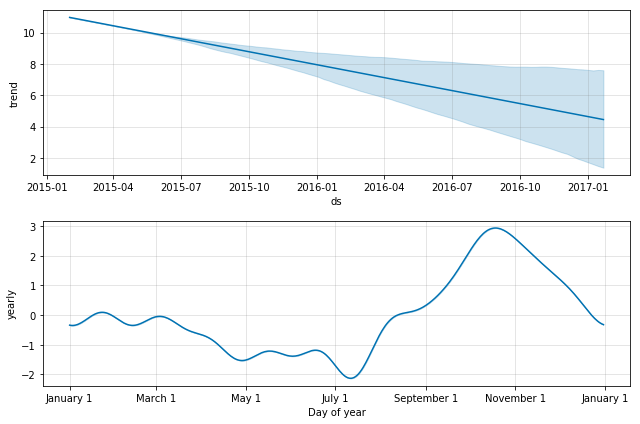

In [30]:
m.plot_components(forecast)
